## Temporal Block Simulations

In [1]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from multiprocessing import Pool
from functools import partial
import pandas as pd
import scipy
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.process_sims import extract_runs, load_pickled, load_stats
from cvtk.process_sims import params_vary_over, col_palette, average_runs
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [5]:
max_nreps = 20

In [6]:
BLOCK_DATADIR = "../data/sims_intermediate/expfit_blocks/"
EVERYGEN_DATADIR = "../data/sims_intermediate/split_exp/"

## Covariance Under Truncation Selection

Here, we're only looking at 1000 sampled individuals (e.g. no bottleneck), and one population.

In [7]:
converters = dict(N=int, alpha=float, nmu=float, rbp=float, tmu=float,
                  Va=float, mag=float, L = int,
                  region_length=int, sampleN=int, shifttime=int, tail=float)

block_results = load_pickled(BLOCK_DATADIR, converters=converters, add_in_Va=True)
everygen_results_orig = load_pickled(EVERYGEN_DATADIR, converters=converters, add_in_Va=True)

In [8]:
len(block_results)

3

Subset all regular results with the parameters for the temopral block covariances.

In [9]:
everygen_results = defaultdict(list)

for key in block_results:
    everygen_results[key].extend(everygen_results_orig[key])

In [10]:
stacked_block_results = average_runs(extract_runs({'Va':[0.01]}, block_results))
stacked_everygen_results = average_runs(extract_runs({'Va':[0.01]}, everygen_results))


/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


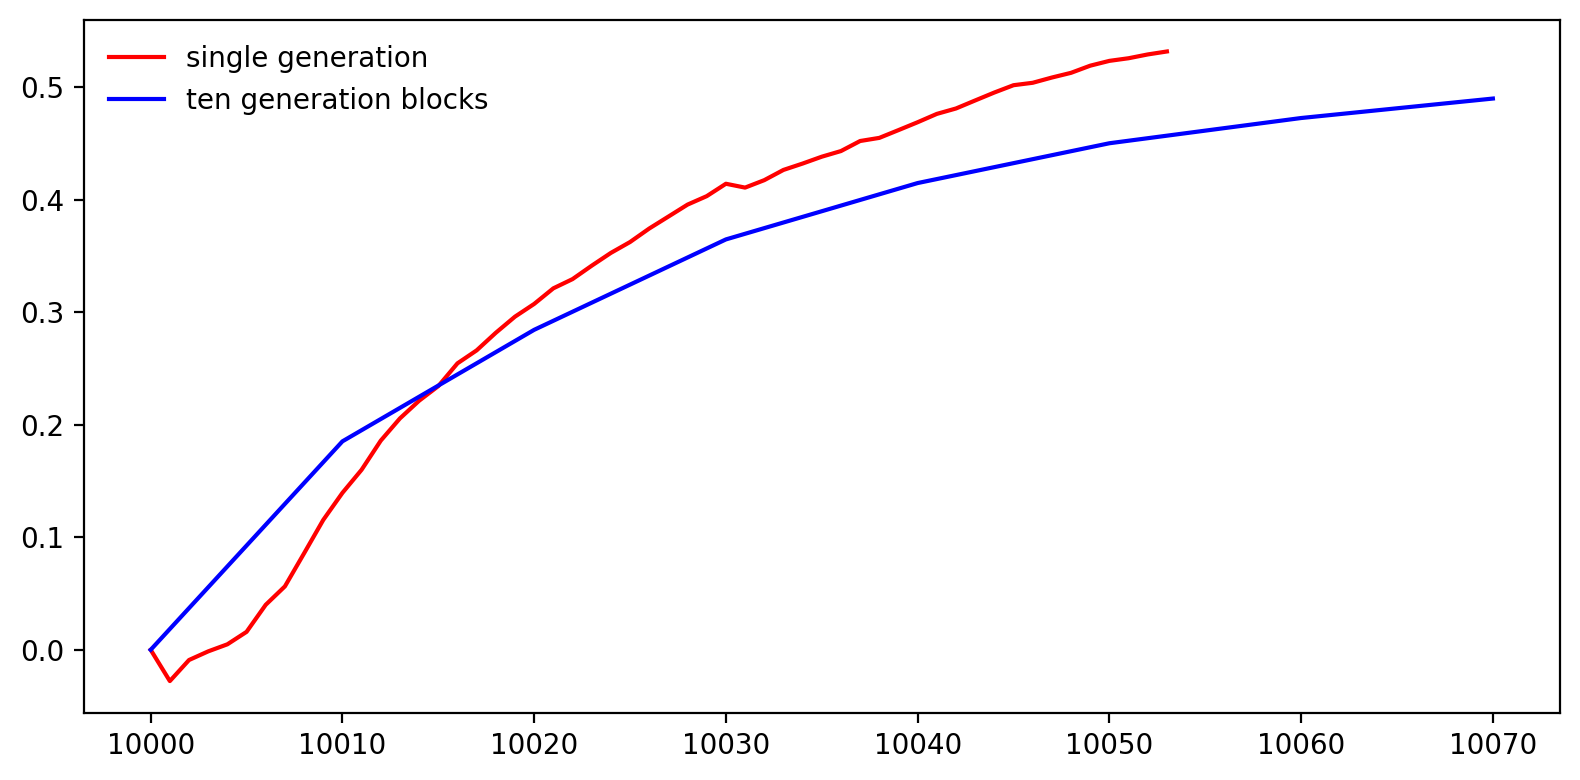

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1)

block_gens = np.arange(10000, 10000 + 100, 10)[:-2]
everygen_gens = np.arange(10000, 10000 + 55, 1)[:-1]
          
maxgen = 20
ref = 5

# crap you need to do because matplotlib...
labset = set()
   
for params, (covs, Gs, dim) in stacked_everygen_results.items():
    params = dict(params)
    
    cov = covs.mean(axis=0)
    lab = 'single generation'
    ax.plot(everygen_gens, Gs.mean(axis=0)[:, 0], '-', label=lab, alpha=1, c='r')
#     for i in range(covs.shape[0]):
#         G = Gs[i, :, 0]
#         lab = 'single generation' if i == 0 else ''
#         ax.plot(everygen_gens, G, '-', label=lab, alpha=1, c='r')
#         ax.set_xlabel("generation")
#         ax.set_ylabel("G")
#         ax.set_title("")
#         ax.axhline(0, c='0.5', linewidth=1)    

for params, (covs, Gs, dim) in stacked_block_results.items():
    params = dict(params)
    
    cov = covs.mean(axis=0)
    lab = 'ten generation blocks'
    ax.plot(block_gens, Gs.mean(axis=0)[:, 0], '-', label=lab, alpha=1, c='b')
#     for i in range(covs.shape[0]):
#         G = Gs[i, :, 0]
#         lab = 'ten generation blocks' if i == 0 else ''
#         ax.plot(block_gens, G, '-', label=lab, alpha=1, c='b')
#         ax.set_xlabel("generation")
#         ax.set_ylabel("G")
#         ax.set_title("")
#         ax.axhline(0, c='0.5', linewidth=1)

ax.legend(frameon=False)
plt.tight_layout()

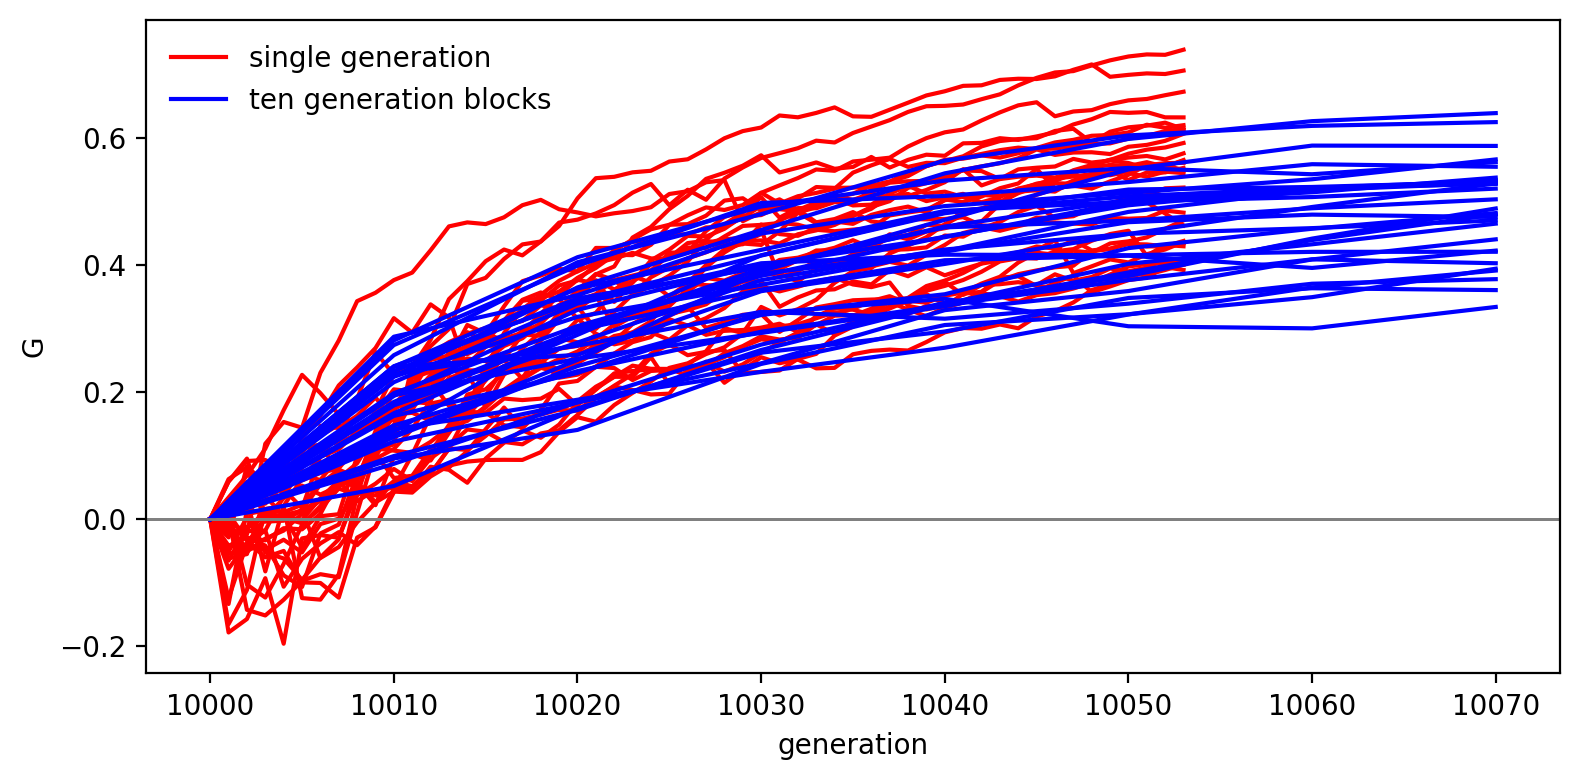

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1)

block_gens = np.arange(10000, 10000 + 100, 10)[:-2]
everygen_gens = np.arange(10000, 10000 + 55, 1)[:-1]
          
maxgen = 20
ref = 5

# crap you need to do because matplotlib...
labset = set()
   
for params, (covs, Gs, dim) in stacked_everygen_results.items():
    params = dict(params)
    
    cov = covs.mean(axis=0)
  
    for i in range(covs.shape[0]):
        G = Gs[i, :, 0]
        lab = 'single generation' if i == 0 else ''
        ax.plot(everygen_gens, G, '-', label=lab, alpha=1, c='r')
        ax.set_xlabel("generation")
        ax.set_ylabel("G")
        ax.set_title("")
        ax.axhline(0, c='0.5', linewidth=1)    

for params, (covs, Gs, dim) in stacked_block_results.items():
    params = dict(params)
    
    cov = covs.mean(axis=0)
    for i in range(covs.shape[0]):
        G = Gs[i, :, 0]
        lab = 'ten generation blocks' if i == 0 else ''
        ax.plot(block_gens, G, '-', label=lab, alpha=1, c='b')
        ax.set_xlabel("generation")
        ax.set_ylabel("G")
        ax.set_title("")
        ax.axhline(0, c='0.5', linewidth=1)

ax.legend(frameon=False)
plt.tight_layout()

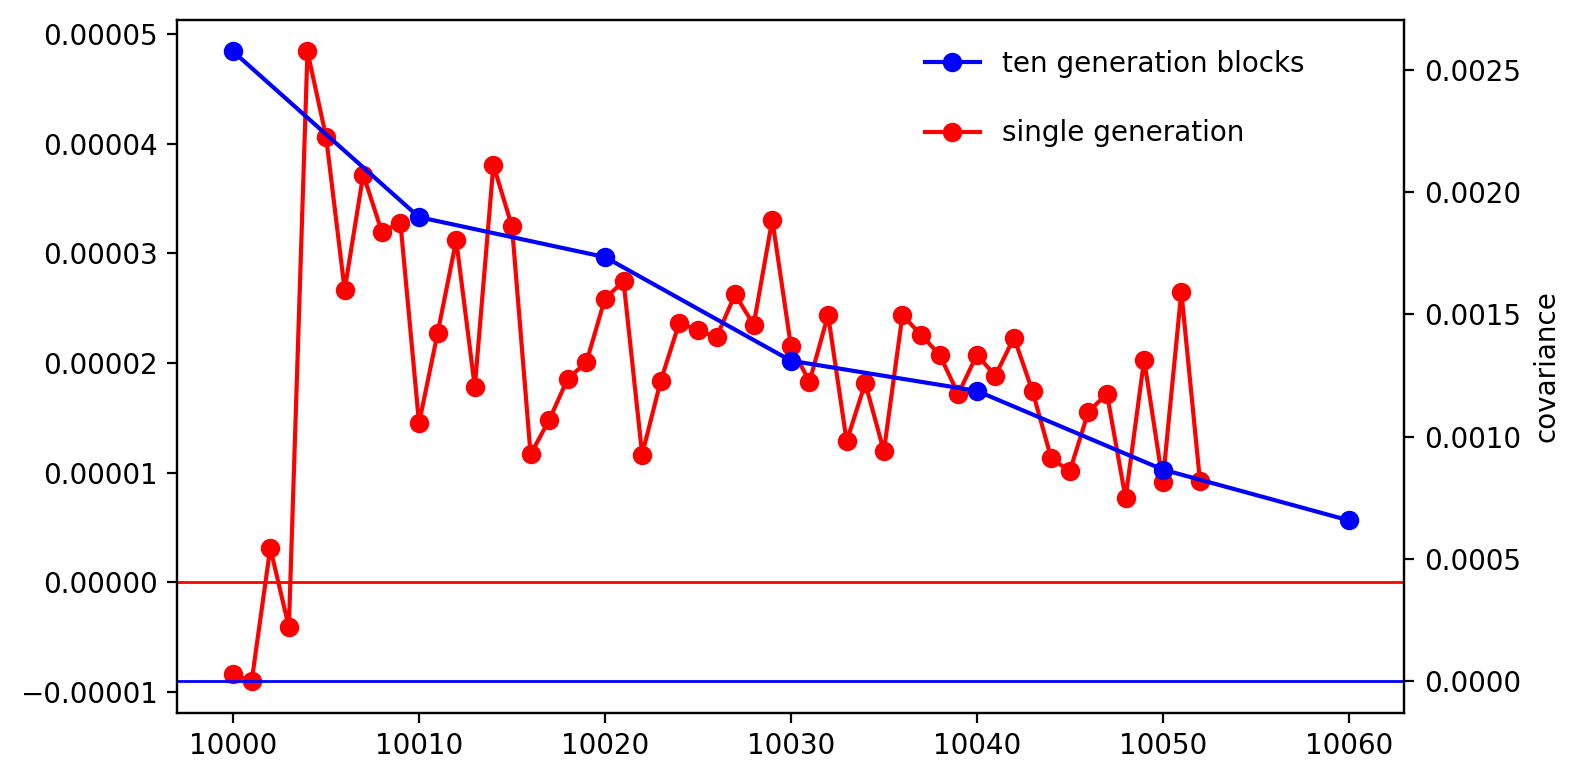

In [43]:
fig, ax = plt.subplots(ncols=1, nrows=1)

block_gens = np.arange(10000, 10000 + 100, 10)[:-3]
everygen_gens = np.arange(10000, 10000 + 55, 1)[:-2]
          
maxgen = 55
ref = 6
R = 2
T = 55

# crap you need to do because matplotlib...
labset = set()
   
for params, (covs, Gs, dim) in stacked_everygen_results.items():
    params = dict(params)
    
    cov = covs.mean(axis=0)
    mean_cov = stack_temporal_covariances(cov, dim[0], dim[1])

    lab = 'single generation'
    n = mean_cov.shape[0] # assumes these are all the same shape
    ref = 5
    idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
    ax.plot(everygen_gens[:(maxgen-1)], mean_cov[ref, idx, 0], '-o', label=lab, alpha=1, c='r')
    ax.set_title("")
    ax.axhline(0, c='r', linewidth=1)    

ax2 = ax.twinx() 
for params, (covs, Gs, dim) in stacked_block_results.items():
    params = dict(params)
    
    cov = covs.mean(axis=0)
    ref = 0
    n = cov.shape[0] # assumes these are all the same shape
    idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)    
    lab = 'ten generation blocks'
    ax2.plot(block_gens[:(maxgen-1)], cov[ref, idx], '-o', label=lab, alpha=1, c='b')
    ax2.set_xlabel("generation")
    ax2.set_ylabel("covariance")
    ax2.set_title("")
    ax2.axhline(0, c='b', linewidth=1)

ax.legend(loc=(0.6, 0.8), frameon=False)
ax2.legend(loc=(0.6, 0.9), frameon=False)
plt.tight_layout()